### **Import all require packages for ETL Process**


In [ ]:
import boto3
import pandas as pd
import numpy as np
import psycopg2
import json
import matplotlib.pyplot as plt
import sqlalchemy as sa
from sqlalchemy.engine.url import URL
from sqlalchemy import orm as sa_orm

### **Establishing AWS Connection ensures out data is loaded into cloud database consistantly and flow is maintained**

## **AWS IAM User Credentials**

In [ ]:
ACCESS_KEY_ID = ""
SECRET_ACCESS_KEY = ""

## **Python AWS SDK (boto3) connect**

In [ ]:
# ec2 resource for attaching VPC
ec2 = boto3.resource('ec2',
                     region_name="us-east-1",
                     aws_access_key_id=ACCESS_KEY_ID,
                     aws_secret_access_key=SECRET_ACCESS_KEY
                  )

# s3 client to store csv data
s3 = boto3.resource('s3',
                     region_name="us-east-1",
                     aws_access_key_id=ACCESS_KEY_ID,
                     aws_secret_access_key=SECRET_ACCESS_KEY
                    )

# iam roles
iam = boto3.client('iam',
                     region_name="us-east-1",
                     aws_access_key_id=ACCESS_KEY_ID,
                     aws_secret_access_key=SECRET_ACCESS_KEY
                    )
# redshift client to store in DB
redshift = boto3.client('redshift',
                     region_name="us-east-1",
                     aws_access_key_id=ACCESS_KEY_ID,
                     aws_secret_access_key=SECRET_ACCESS_KEY
                    )



In [ ]:
# access to S3 bucket
bucket = s3.Bucket("inputetlbucket")
log_data_files = [f.key for f in bucket.objects.filter(Prefix='')]
log_data_files

[]

In [ ]:
# Fetch Redshift IAM role
redshift_role_arn = iam.get_role(RoleName="RedshiftS3FullAccessRole")['Role']['Arn']
redshift_role_arn

'arn:aws:iam::022341756463:role/RedshiftS3FullAccessRole'

In [ ]:
# Redshift cluster credentials
CLUSTER_TYPE = 'single-node'
NODE_TYPE = 'dc2.large'
DB_NAME = ''
CLUSTER_IDENTIFIER = ''
DB_USER = ''
DB_PASSWORD = ''
PORT = 5439

In [ ]:
# Create Redshift Cluster
try:
  response = redshift.create_cluster(
      ClusterType=CLUSTER_TYPE,
      NodeType=NODE_TYPE,
      DBName=DB_NAME,
      ClusterIdentifier=CLUSTER_IDENTIFIER,
      MasterUsername=DB_USER,
      MasterUserPassword=DB_PASSWORD,
      IamRoles=[redshift_role_arn]
    )
except Exception as e:
  print(e)

An error occurred (ClusterAlreadyExists) when calling the CreateCluster operation: Cluster already exists


In [ ]:
# redshift resource properies
rs_response = redshift.describe_clusters(ClusterIdentifier=CLUSTER_IDENTIFIER)

In [ ]:
# attach vpc to redshift
redshift_VpcId = rs_response['Clusters'][0]['VpcId']

try:
  vpc = ec2.Vpc(id=redshift_VpcId)
  defaultsg = list(vpc.security_groups.all())[0]
  print(defaultsg)

  defaultsg.authorize_ingress(
      GroupName=defaultsg.group_name,
      CidrIp='0.0.0.0/0',
      IpProtocol='TCP',
      FromPort=PORT,
      ToPort=PORT
  )
except Exception as e:
  print(e)

ec2.SecurityGroup(id='sg-00661d48a4180b6f8')
An error occurred (InvalidPermission.Duplicate) when calling the AuthorizeSecurityGroupIngress operation: the specified rule "peer: 0.0.0.0/0, TCP, from port: 5439, to port: 5439, ALLOW" already exists


## **Extract Data from Spreadsheet**

In [ ]:
df = pd.read_excel('WS.xlsx')

In [ ]:
# daata type che check for DB loading
print("Dataframe Shape : ", df.shape)
df.info()

Dataframe Shape :  (1629, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629 entries, 0 to 1628
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          1629 non-null   object 
 1   Company Name                1629 non-null   object 
 2   Number of Employees         1613 non-null   float64
 3   % Developers Count          1209 non-null   float64
 4   Estimated Developers Count  1248 non-null   float64
 5   Developers on LinkedIn      425 non-null    object 
 6   Business Description        1608 non-null   object 
 7   Region of Headquarters      1611 non-null   object 
 8   Country of Headquarters     1611 non-null   object 
 9   Revenue                     1394 non-null   float64
 10  Currency                    1629 non-null   object 
 11  TRBC Economic Sector Name   1606 non-null   object 
 12  TRBC Business Sector Name   1373 non-null   object 
 13  TRB

In [ ]:
# check missing data
df.isna().mean()*100

ID                             0.000000
Company Name                   0.000000
Number of Employees            0.982198
% Developers Count            25.782689
Estimated Developers Count    23.388582
Developers on LinkedIn        73.910374
Business Description           1.289134
Region of Headquarters         1.104972
Country of Headquarters        1.104972
Revenue                       14.426028
Currency                       0.000000
TRBC Economic Sector Name      1.411909
TRBC Business Sector Name     15.715163
TRBC Industry Group Name      15.837937
URL                            2.332719
Sales Person                   0.000000
Sales Person Email             0.000000
Days Since First Contact       0.552486
dtype: float64

In [ ]:
# check for duplicate data
df.duplicated().mean()*100

0.0

## **Transform Data**

In [ ]:
# drop unneccessary columns
df.drop(columns=['Developers on LinkedIn','Business Description','URL','Days Since First Contact','Sales Person Email','Sales Person'],axis=1,inplace=True)

In [ ]:
# fill empty (NA) values with average percentage
df['% Developers Count'].fillna(df['% Developers Count'].mean(),inplace=True)

In [ ]:
# fill empty values of Estimated developers using number_of_employees and % developers count
df['Estimated Developers Count'].fillna((df['Number of Employees']*df['% Developers Count']),inplace=True)

In [ ]:
# flattening data of denormalized columns
denormalized_indices = list(df.loc[df['% Developers Count'] > 1].index)
for index in denormalized_indices:
  df.at[index,'% Developers Count'] = df.loc[[index]]['% Developers Count']/100
  df.at[index, 'Estimated Developers Count'] = df.loc[[index]]['Number of Employees'] * df.loc[[index]]['% Developers Count']

In [ ]:
# drop rows having missing values in specific columns
df = df.dropna(subset=['Number of Employees', '% Developers Count','Estimated Developers Count','Region of Headquarters','Country of Headquarters','TRBC Economic Sector Name','TRBC Business Sector Name','TRBC Industry Group Name'])

In [ ]:
# drop rows with all empty values
df = df.dropna(how = 'all')

In [ ]:
# check currency types
df["Currency"].value_counts()

GBP (£)    786
USD($)     406
USD ($)    178
Name: Currency, dtype: int64

In [ ]:
# transform currency into uniform unit - USD
def convert(row):
  if row["Currency"] == "GBP (£)":
    return row["Revenue"] *  1.09
  else:
    return row["Revenue"]

df['Revenue (USD)'] = df.apply(lambda row: convert(row), axis=1)

In [ ]:
# drop revenue and currency column
df.drop(columns=['Revenue','Currency'],axis=1,inplace=True)

In [ ]:
# fill empty revenue cells with Aggregate values like Median
# Reason : Median being the middle point of frequncy distiribution
df['Revenue (USD)'].fillna(df['Revenue (USD)'].median(),inplace=True)

In [ ]:
df.isna().mean()*100

ID                            0.0
Company Name                  0.0
Number of Employees           0.0
% Developers Count            0.0
Estimated Developers Count    0.0
Region of Headquarters        0.0
Country of Headquarters       0.0
TRBC Economic Sector Name     0.0
TRBC Business Sector Name     0.0
TRBC Industry Group Name      0.0
Revenue (USD)                 0.0
dtype: float64

In [ ]:
# data type conversion
df['Number of Employees'] = df['Number of Employees'].astype(int)
df['Estimated Developers Count'] = df['Estimated Developers Count'].astype(int)

In [ ]:
# data precision
df.round({"% Developers Count":2, "Revenue (USD)":2})

,ID,Company Name,Number of Employees,% Developers Count,Estimated Developers Count,Region of Headquarters,Country of Headquarters,TRBC Economic Sector Name,TRBC Business Sector Name,TRBC Industry Group Name,Revenue (USD)
0,INTC.OQ,Intel Corp,110600,0.06,6857,Americas,USA,Technology,Technology Equipment,Semiconductors & Semiconductor Equipment,7.541000e+10
1,TEMN.S,Temenos AG,7828,0.19,1521,Europe,Switzerland,Technology,Software & IT Services,Software & IT Services,9.318050e+08
2,V.N,Visa Inc,20500,0.19,3983,Americas,United States of America,Technology,Software & IT Services,Software & IT Services,2.264700e+10
3,CABK.MC,Caixabank SA,51071,0.06,3140,Europe,Spain,Financials,Banking & Investment Services,Banking Services,1.094014e+10
4,TGT.N,Target Corp,409000,0.01,4130,Americas,United States of America,Consumer Cyclicals,Retailers,Diversified Retail,1.003280e+11
...,...,...,...,...,...,...,...,...,...,...,...
1619,MCGJ.J,MultiChoice Group Ltd,7028,0.04,302,Africa,South Africa,Consumer Cyclicals,Cyclical Consumer Services,Media & Publishing,3.702898e+09
1620,GTN.N,Gray Television Inc,7017,0.04,302,Americas,United States of America,Consumer Cyclicals,Cyclical Consumer Services,Media & Publishing,2.487000e+09
1621,4676.T,Fuji Media Holdings Inc,6880,0.04,296,Asia,Japan,Consumer Cyclicals,Cyclical Consumer Services,Media & Publishing,4.781680e+09
1622,ASOK.NS,Ashok Leyland Ltd,10758,0.03,277,Asia,India,Consumer Cyclicals,Automobiles & Auto Parts,Automobiles & Auto Parts,2.377355e+09


# **Loading Data into DB**

## **Option 1 : Redshift Database (Data Warehouse)**

In [ ]:
RS_CLUSTER_ADDRESS = rs_response['Clusters'][0]['Endpoint']['Address']

# build the sqlalchemy URL
url = URL.create(
drivername='redshift+redshift_connector',
host=RS_CLUSTER_ADDRESS,
port=PORT,
database=DB_NAME,
username=DB_USER,
password=DB_PASSWORD
)

# create engine
engine = sa.create_engine(url)

# session
Session = sa_orm.sessionmaker()
Session.configure(bind=engine)
session = Session()

# Define Session-based Metadata
metadata = sa.MetaData(bind=session.bind)

# load data to db
try:
  df.to_sql('bench', engine, index=False, if_exists='replace')
except psycopg2.Error as e:
  print('Error : Failed creating table !')
  print(e)


In [ ]:
# close session
session.close()

# If the connection was accessed directly, make it invalidated
conn = engine.connect()
conn.invalidate()

# Clean up the engine
engine.dispose()

## **Option 2 : AWS S3 (CSV File Storage)**

In [ ]:
# save transformed file as csv and upload to AWS S3
df.to_csv("WS.csv",index=False)
s3.Bucket('inputetlbucket').upload_file('WS.csv','WS.CSV')

# **Metrices & Visualization**



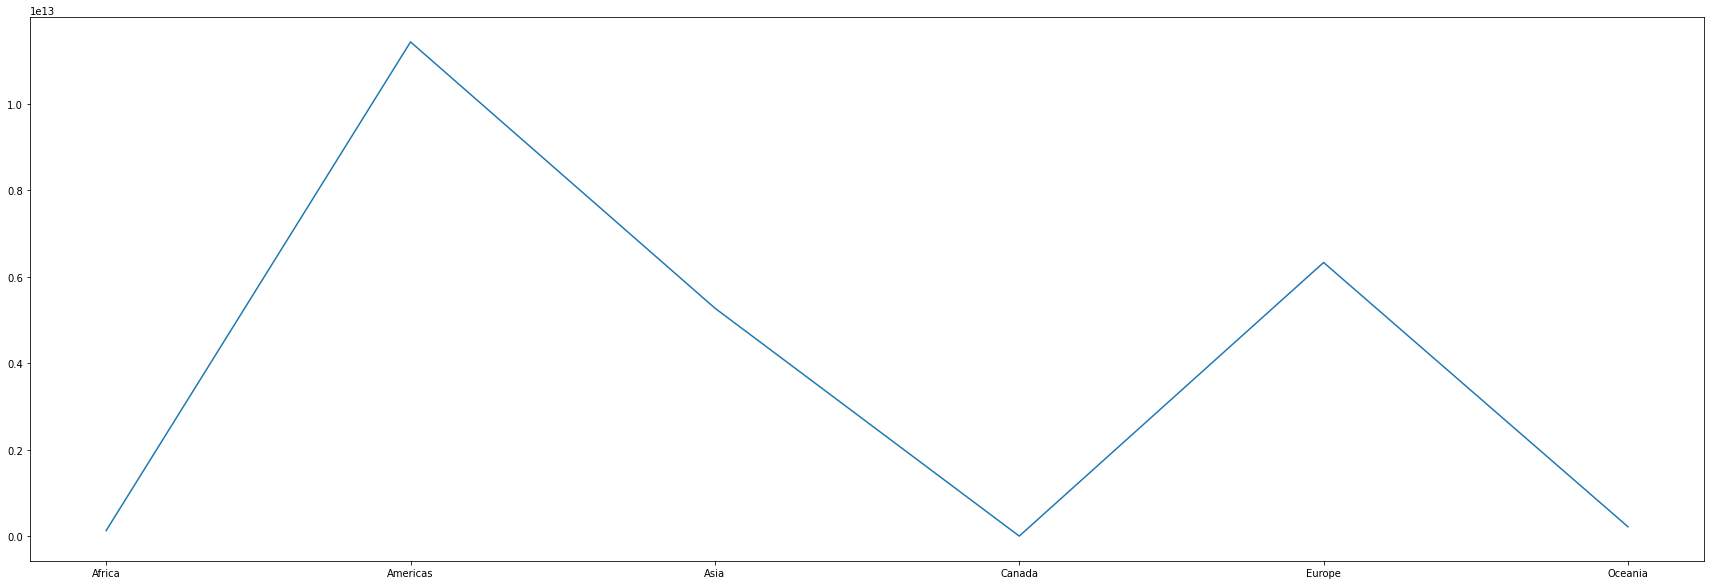

In [ ]:
# annual revenue sum by region
plt.figure(figsize=(30,10))
plt.plot(df.groupby('Region of Headquarters').agg({"Revenue (USD)":"sum"}))

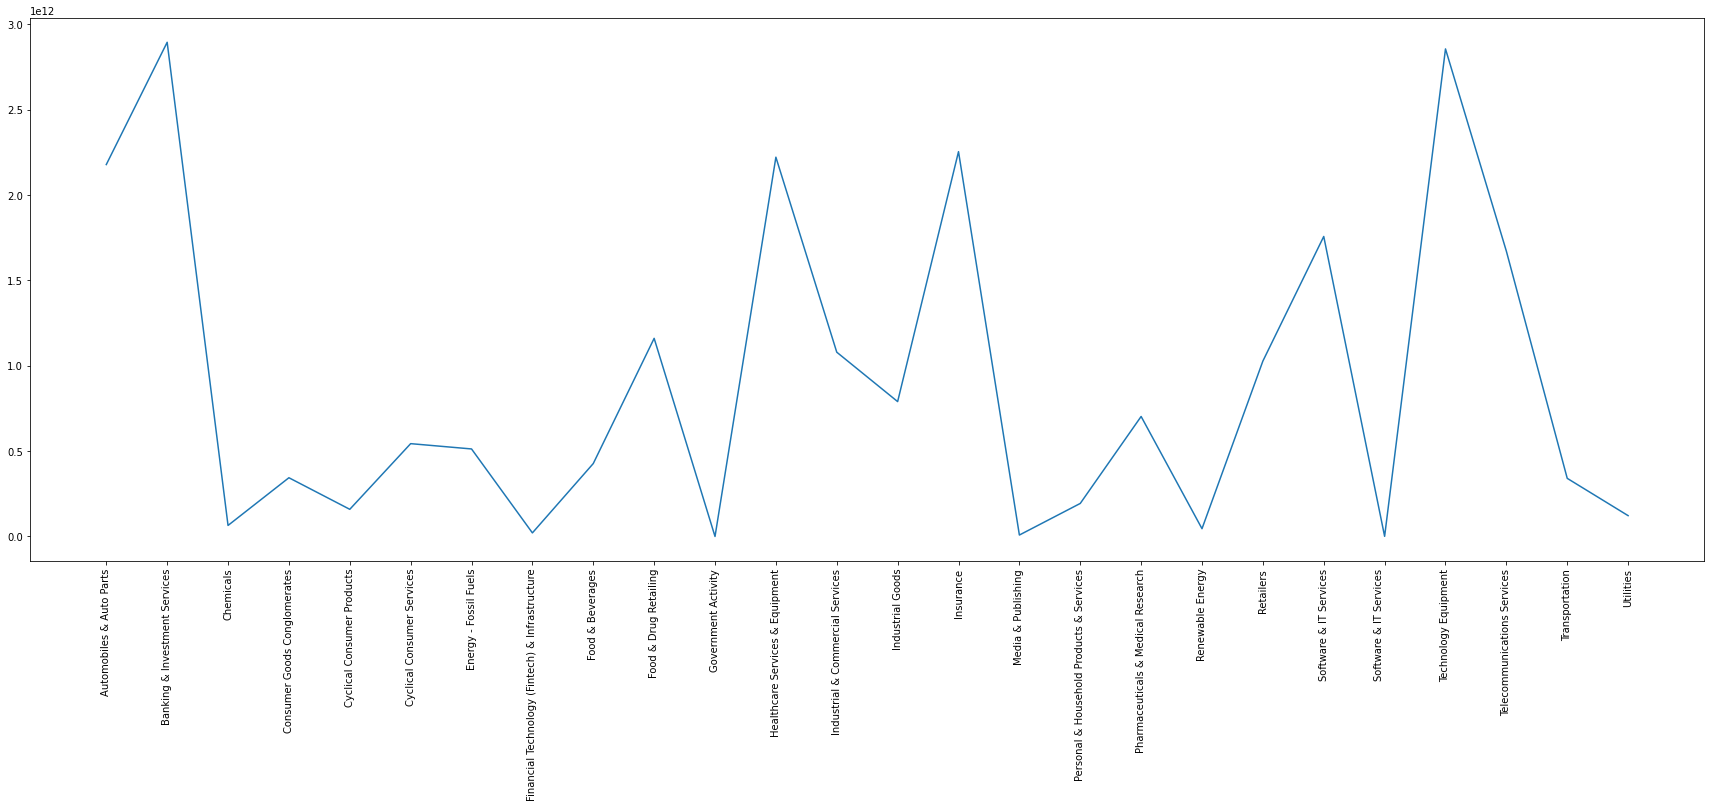

In [ ]:
# annual revenue by business sector
plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
plt.plot(df.groupby('TRBC Business Sector Name').agg({"Revenue (USD)":"sum"}))

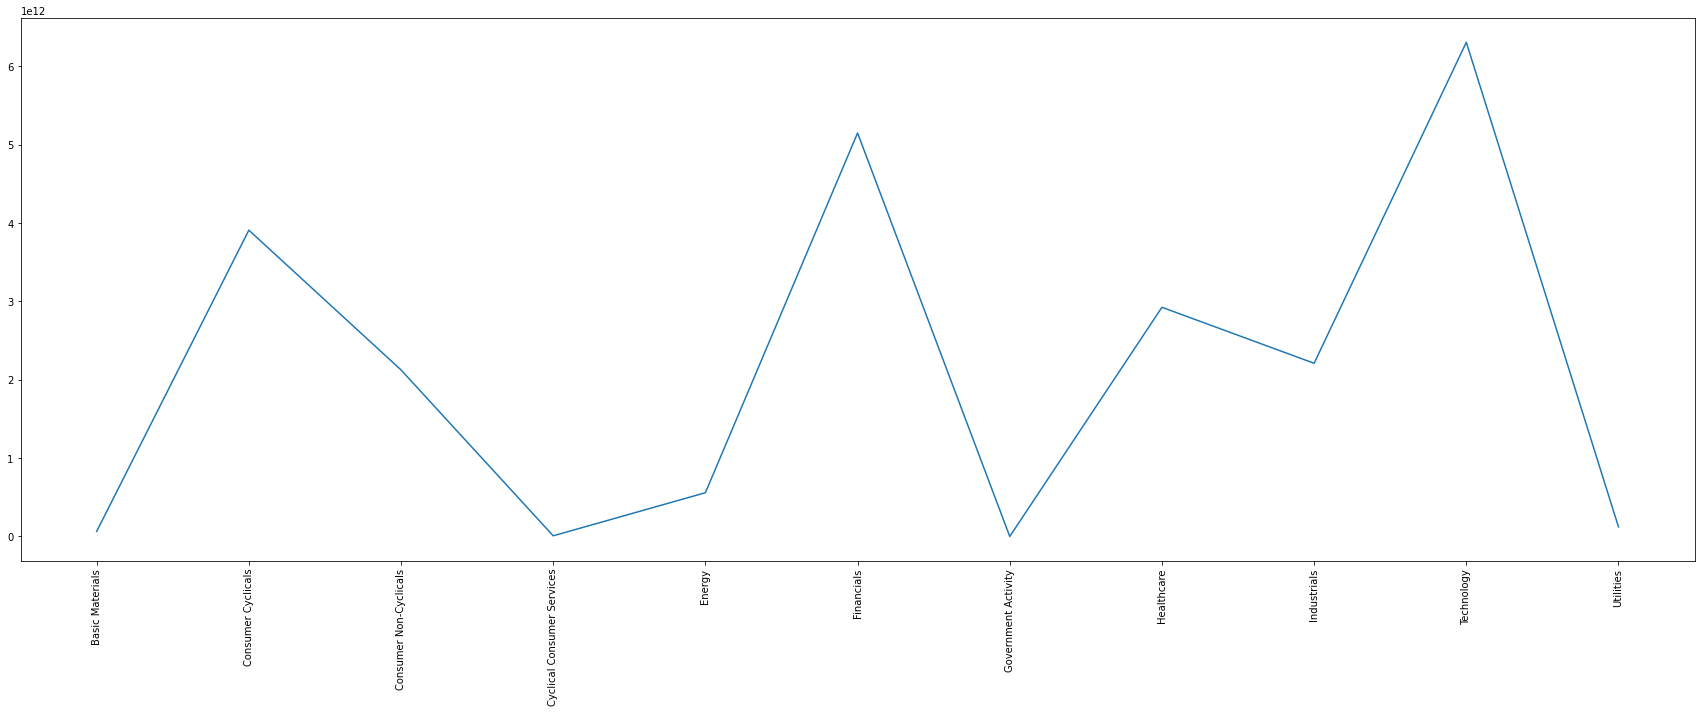

In [ ]:
# annual revenue by economic sector
plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
plt.plot(df.groupby('TRBC Economic Sector Name').agg({"Revenue (USD)":"sum"}))

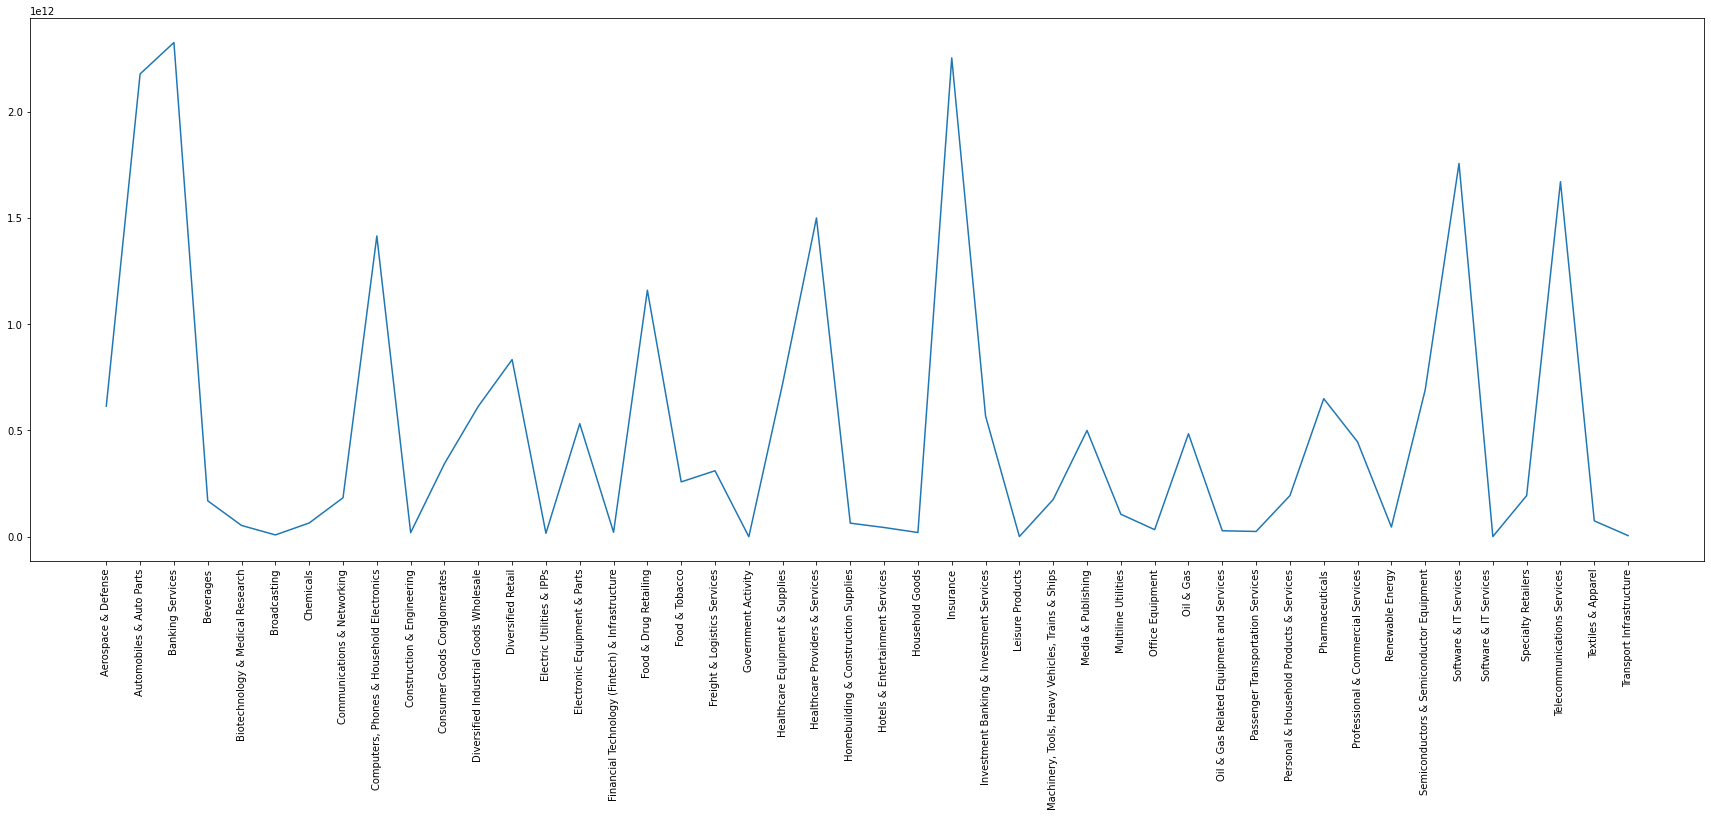

In [ ]:
# annual revenue by economic sector
plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
plt.plot(df.groupby('TRBC Industry Group Name').agg({"Revenue (USD)":"sum"}))

In [ ]:
# employ data metrics by headquarter
emp_df = df.groupby('Region of Headquarters').agg({"Number of Employees":"sum"})
emp_df

,Number of Employees
Region of Headquarters,
Africa,605857
Americas,23955675
Asia,14538533
Canada,900
Europe,19630268
Oceania,647738


In [ ]:
# developer data metrics by headquarter
est_dev_df = df.groupby('Region of Headquarters').agg({"Estimated Developers Count":"sum"})
est_dev_df

,Estimated Developers Count
Region of Headquarters,
Africa,50903
Americas,1815605
Asia,1239231
Canada,127
Europe,1614383
Oceania,58061


# **END OF PIPELINE**